# Comparing kelp forest health
<br>

This file:
1) imports PACE OCI data from a kelp forest (tbd)
2) creates functions for QWIP analysis and to separate OCI data into three AVW types: blue, green, and brown
3) classifies kelp forest into three color groups
4) assesses percentage of color classes over a period of time

## First we import kelp forest data from PACE
bbox defines kelp forest area: change if interested in different area

In [1]:
# import packages we'll need
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

# login to earthaccess
auth = earthaccess.login(persist=True)

#sb lter bbox
# note: bounding boxes are for level 2 data
bbox = (-120.127183, 34.381217, -119.531183, 34.477467) #estimating kelp forest size
# access data from sb lter 
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-09", "2025-03-09"), # okay cool found a day that doesn't suck
    bounding_box = bbox
)

fileset = earthaccess.open(results);

# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 40, 12)})

## Lets quickly check what this looks like with a plot
If you change the bbox above, adjust the image boundaries here

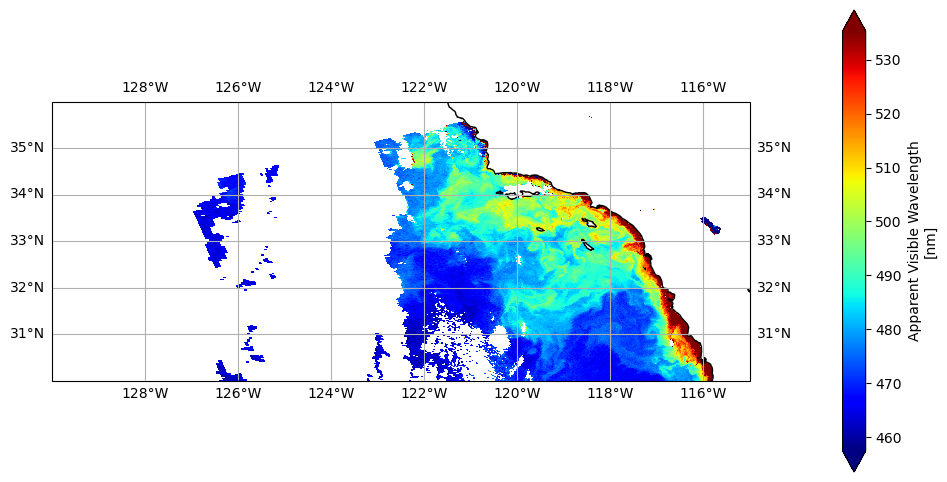

In [2]:
rrs_da = ds["Rrs"]
avw_da = ds["avw"]
wavelengths = ds["wavelength_3d"]

# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# Get the figure set up, add a map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Put some lines in there so we know where we are
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop the image down a bit so we can focus on an area
ax.set_extent([-130, -115, 30, 36], crs=ccrs.PlateCarree())

# Plot and adjust colorbar limits, put "pad" argument in there to move the colorbar away from the image (otherwise it overlaps)
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, cbar_kwargs={"pad": 0.1})

## QWIP processing 
Thanks Ryan and James for this!

In [2]:
"""QWIP (quality water index polynomial) helpers and plots.

This module computes QWIP metrics from water-leaving reflectance spectra and
provides convenience plotting. The workflow is:

1. Subset to visible wavelengths (e.g., 400–700 nm).
2. Compute AVW (apparent visible wavelength) and integrated brightness.
3. Compute NDI(490,665) and a polynomial prediction vs AVW.
4. Classify spectra into 400A/500A/600A types and flag QWIP outliers.

Public API
----------
- :func:`calc_avw`
- :func:`calc_brightness`
- :func:`process_qwip_data`
- :func:`plot_qwip`
- :func:`plot_normalized_spectra`
- :func:`run_qwip_analysis`

"""

from __future__ import annotations

from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.integrate import trapezoid

__all__ = [
    "QwipResults",
    "calc_avw",
    "calc_brightness",
    "process_qwip_data",
    "plot_qwip",
    "plot_normalized_spectra",
    "run_qwip_analysis",
]


class QwipResults(TypedDict):
    """Container for QWIP outputs from :func:`process_qwip_data`."""

    avw: np.ndarray
    NDI: np.ndarray
    QWIP_Score: np.ndarray
    ind_400A: np.ndarray  # bool mask
    ind_500A: np.ndarray  # bool mask
    ind_600A: np.ndarray  # bool mask
    poly_coeffs: np.ndarray
    failed_indices: np.ndarray  # int idx array
    passed_indices: np.ndarray  # int idx array


def calc_avw(wavelengths: np.ndarray, rrs: np.ndarray) -> np.ndarray:
    """Calculate Apparent Visible Wavelength (AVW).

    AVW is defined here as::

        AVW = sum(Rrs) / sum(Rrs / lambda)

    Parameters
    ----------
    wavelengths
        1-D array of wavelengths (nm) of shape ``(n_wl,)``.
    rrs
        Water-leaving reflectance array of shape ``(n_samples, n_wl)`` or
        ``(n_wl,)``. If 1-D, it is treated as one sample.

    Returns
    -------
    numpy.ndarray
        AVW per sample, shape ``(n_samples,)``.

    Raises
    ------
    ValueError
        If the wavelengths length does not match the reflectance spectral axis.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.atleast_2d(np.asarray(rrs, dtype=float))
    if X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")

    num = np.sum(X, axis=1)
    with np.errstate(invalid="ignore", divide="ignore"):
        den = np.sum(X / wl, axis=1)
        avw = num / den
    return avw


def calc_brightness(wavelengths: np.ndarray, rrs: np.ndarray) -> np.ndarray:
    """Calculate integrated “brightness” using the trapezoidal rule.

    Parameters
    ----------
    wavelengths
        1-D array of wavelengths (nm) of shape ``(n_wl,)``.
    rrs
        Reflectance array of shape ``(n_samples, n_wl)`` or ``(n_wl,)``.

    Returns
    -------
    numpy.ndarray
        Integral per sample, shape ``(n_samples,)``.

    Raises
    ------
    ValueError
        If the wavelength length does not match the reflectance spectral axis.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.atleast_2d(np.asarray(rrs, dtype=float))
    if X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")
    return trapezoid(y=X, x=wl, axis=-1)


def process_qwip_data(
    wavelengths: np.ndarray,
    rrs: np.ndarray,
    avw: np.ndarray,
) -> QwipResults:
    """Compute QWIP masks and scores for spectra.

    Parameters
    ----------
    wavelengths
        1-D array of wavelengths (nm), shape ``(n_wl,)``.
    rrs
        Reflectance array of shape ``(n_samples, n_wl)``.
    avw
        Apparent Visible Wavelength per sample, shape ``(n_samples,)``.

    Returns
    -------
    QwipResults
        Typed mapping with AVW, NDI, QWIP_Score, type masks, and pass/fail indices.

    Notes
    -----
    - NDI is computed as ``(Rrs665 - Rrs490) / (Rrs665 + Rrs490)``.
    - The polynomial coefficients are fixed (Balasubramanian 2020 fit).
    - Fail criteria: type-range violations OR ``|QWIP_Score| > 0.2``.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.asarray(rrs, dtype=float)
    if X.ndim != 2:
        raise ValueError("rrs must be a 2-D array (n_samples, n_wl)")
    if X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")
    avw = np.asarray(avw, dtype=float).reshape(-1)
    if avw.shape[0] != X.shape[0]:
        raise ValueError("avw length must match number of spectra in rrs")

    # Find nearest indices to target wavelengths
    idx490 = int(np.argmin(np.abs(wl - 490.0)))
    idx560 = int(np.argmin(np.abs(wl - 560.0)))
    idx665 = int(np.argmin(np.abs(wl - 665.0)))

    # Normalized Difference Index (NDI)
    num = X[:, idx665] - X[:, idx490]
    den = X[:, idx665] + X[:, idx490]
    with np.errstate(invalid="ignore", divide="ignore"):
        ndi = num / den

    # Polynomial coefficients for NDI vs AVW
    p = np.array(
        [-8.399885e-09, 1.715532e-05, -1.301670e-02, 4.357838, -5.449532e02],
        dtype=float,
    )

    # Type masks (Balasubramanian 2020)
    step1 = X[:, idx665] > X[:, idx560]
    step2 = X[:, idx665] > 0.025
    step3 = X[:, idx560] < X[:, idx490]

    ind_600A = step1 | step2
    ind_500A = (~step1 & ~step2) & ~step3
    ind_400A = (~step1 & ~step2) & step3

    # QWIP score (difference from polynomial prediction)
    ndi_pred = np.polyval(p, avw)
    qwip_score = ndi - ndi_pred

    # --- Classification Logic ---

    # Fail flags
    failed_400 = ind_400A & ((avw < 410.0) | (avw > 520.0))
    failed_500 = ind_500A & ((avw < 490.0) | (avw > 590.0))
    failed_600 = ind_600A & ((avw < 550.0) | (avw > 600.0))
    type_failure = failed_400 | failed_500 | failed_600
    qwip_failure = (qwip_score < -0.2) | (qwip_score > 0.2)

    is_failed = type_failure | qwip_failure
    failed_indices = np.where(is_failed)[0]
    passed_indices = np.where(~is_failed)[0]

    return QwipResults(
        avw=avw,
        NDI=ndi,
        QWIP_Score=qwip_score,
        ind_400A=ind_400A,
        ind_500A=ind_500A,
        ind_600A=ind_600A,
        poly_coeffs=p,
        failed_indices=failed_indices,
        passed_indices=passed_indices,
    )


def plot_qwip(
    results: QwipResults,
    title: str = "QWIP Analysis",
    *,
    show: bool = True,
):
    """Generate a QWIP scatter with polynomial bands.

    Parameters
    ----------
    results
        Output from :func:`process_qwip_data`.
    title
        Plot title.
    show
        If ``True`` (default), call :func:`matplotlib.pyplot.show`. If ``False``,
        the caller is responsible for drawing/closing the figure.

    Returns
    -------
    (fig, ax)
        Matplotlib figure and axis.

    """
    avw = results["avw"]
    ndi = results["NDI"]
    ind_400A = results["ind_400A"]
    ind_500A = results["ind_500A"]
    ind_600A = results["ind_600A"]
    p = results["poly_coeffs"]

    avw_poly = np.arange(400.0, 631.0)
    fit1 = np.polyval(p, avw_poly)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title, fontsize=18, fontweight="bold")

    # Classified points
    ax.plot(
        avw[ind_400A],
        ndi[ind_400A],
        "ok",
        markersize=5,
        markerfacecolor="b",
        label="Type I Blue-Green",
    )
    ax.plot(
        avw[ind_500A],
        ndi[ind_500A],
        "ok",
        markersize=5,
        markerfacecolor="g",
        label="Type II Green",
    )
    ax.plot(
        avw[ind_600A],
        ndi[ind_600A],
        "ok",
        markersize=5,
        markerfacecolor="r",
        label="Type III Brown",
    )

    # Polynomial & thresholds
    ax.plot(avw_poly, fit1, "-k", linewidth=2)
    ax.plot(avw_poly, fit1 + 0.1, "--g", linewidth=2)
    ax.plot(avw_poly, fit1 - 0.1, "--g", linewidth=2)
    ax.plot(avw_poly, fit1 + 0.2, "--", linewidth=2, color=(0.9290, 0.6940, 0.1250))
    ax.plot(avw_poly, fit1 - 0.2, "--", linewidth=2, color=(0.9290, 0.6940, 0.1250))
    ax.plot(avw_poly, fit1 + 0.3, "--", linewidth=2, color=(0.8500, 0.3250, 0.0980))
    ax.plot(avw_poly, fit1 - 0.3, "--", linewidth=2, color=(0.8500, 0.3250, 0.0980))
    ax.plot(avw_poly, fit1 + 0.4, "-r", linewidth=2)
    ax.plot(avw_poly, fit1 - 0.4, "-r", linewidth=2)

    # Labels and legends
    ax.set_xlabel("AVW (nm)", fontsize=16)
    ax.set_ylabel("NDI (490, 665)", fontsize=16)
    ax.set_ylim(-2.5, 2.0)
    ax.set_xlim(440, 600)
    ax.grid(True, linestyle=":", alpha=0.6)

    legend1 = ax.legend(loc="lower right", title="Data Types", fontsize=12)
    ax.add_artist(legend1)

    legend_lines = [
        Line2D([0], [0], color="g", lw=2, linestyle="--", label="QWIP ± 0.1"),
        Line2D(
            [0],
            [0],
            color=(0.9290, 0.6940, 0.1250),
            lw=2,
            linestyle="--",
            label="QWIP ± 0.2",
        ),
        Line2D(
            [0],
            [0],
            color=(0.8500, 0.3250, 0.0980),
            lw=2,
            linestyle="--",
            label="QWIP ± 0.3",
        ),
        Line2D([0], [0], color="r", lw=2, linestyle="-", label="QWIP ± 0.4"),
    ]
    ax.legend(handles=legend_lines, loc="upper left", title="Thresholds", fontsize=12)

    if show:
        plt.show()
    return fig, ax


def plot_normalized_spectra(
    results: QwipResults,
    wavelengths: np.ndarray,
    rrs: np.ndarray,
    brightness: np.ndarray,
    *,
    title_suffix: str = "",
    show: bool = True,
):
    """Plot brightness-normalized spectra for pass/fail sets, colored by AVW.

    Parameters
    ----------
    results
        Output from :func:`process_qwip_data`.
    wavelengths
        1-D wavelengths (nm), shape ``(n_wl,)``.
    rrs
        Reflectance array, shape ``(n_samples, n_wl)``.
    brightness
        Integrated brightness per sample, from :func:`calc_brightness`.
    title_suffix
        Appended to the figure title.
    show
        If ``True`` (default) call ``plt.show()``; otherwise just return fig/axes.

    Returns
    -------
    (fig, (ax1, ax2))
        Matplotlib figure and axes for passed/failed spectra.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.asarray(rrs, dtype=float)
    if X.ndim != 2 or X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")
    brightness_arr = np.asarray(brightness, dtype=float).reshape(-1)
    if brightness_arr.shape[0] != X.shape[0]:
        raise ValueError("brightness length must match number of spectra in rrs")

    with np.errstate(divide="ignore", invalid="ignore"):
        norm_rrs = X / brightness_arr[:, None]
    norm_rrs[~np.isfinite(norm_rrs)] = np.nan
    passed = results["passed_indices"]
    failed = results["failed_indices"]
    avw = results["avw"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    fig.suptitle(f"Normalized Spectra - {title_suffix}", fontsize=18, fontweight="bold")

    cmap = plt.get_cmap("jet")
    norm = plt.Normalize(vmin=440, vmax=600)

    # Passed
    ax1.set_title(f"Passed Spectra ({len(passed)})", fontsize=14)
    for i in passed:
        ax1.plot(wl, norm_rrs[i, :], color=cmap(norm(avw[i])), alpha=0.6)
    ax1.set_xlabel("Wavelength (nm)", fontsize=12)
    ax1.set_ylabel("Normalized Rrs (Rrs / Brightness)", fontsize=12)

### Prepare data for use in QWIP analysis
We are going to process the data in chunks and pre-subset wavelengths to the visible spectra to reduce memory load.

In [4]:
import numpy as np
from tqdm import tqdm

LINES_PER_CHUNK = 32  # match OCI chunking

# wavelengths + visible subset
wavelengths = ds["wavelength_3d"].values.astype(float)
vis = (wavelengths >= 400) & (wavelengths <= 700)
wavelengths_vis = wavelengths[vis]

n_lines = ds.sizes["number_of_lines"]
n_pixels = ds.sizes["pixels_per_line"]

# create arrays
all_lat = []
all_lon = []

all_avw = []
all_qwip = []

all_ind_400A = []
all_ind_500A = []
all_ind_600A = []

In [5]:
# processing chunk - also filters QWIP to be +/- 0.1
for i0 in tqdm(range(0, n_lines, LINES_PER_CHUNK)):
    i1 = min(i0 + LINES_PER_CHUNK, n_lines)

    # --- slice chunk ---
    Rrs_chunk = (
        ds["Rrs"]
        .isel(number_of_lines=slice(i0, i1))
        .sel(wavelength_3d=wavelengths_vis)
    )

    lat_chunk = ds["latitude"].isel(number_of_lines=slice(i0, i1))
    lon_chunk = ds["longitude"].isel(number_of_lines=slice(i0, i1))

    # --- reshape to (n_samples, n_wl) ---
    Rrs_np = (
        Rrs_chunk
        .transpose("number_of_lines", "pixels_per_line", "wavelength_3d")
        .values
    )

    rrs = Rrs_np.reshape(-1, Rrs_np.shape[-1])

    # --- mask invalid reflectance ---
    rrs[rrs <= 0] = np.nan
    good = np.all(np.isfinite(rrs), axis=1)
    if not np.any(good):
        continue

    rrs = rrs[good]

    # --- QWIP ---
    avw = calc_avw(wavelengths_vis, rrs)
    results = process_qwip_data(wavelengths_vis, rrs, avw)

    # --- keep only QWIP ± 0.1 ---
    good_qwip = np.abs(results["QWIP_Score"]) <= 0.1
    if not np.any(good_qwip):
        continue

    # --- append results ---
    all_avw.append(results["avw"][good_qwip])
    all_qwip.append(results["QWIP_Score"][good_qwip])

    all_ind_400A.append(results["ind_400A"][good_qwip])
    all_ind_500A.append(results["ind_500A"][good_qwip])
    all_ind_600A.append(results["ind_600A"][good_qwip])

    lat_flat = lat_chunk.values.reshape(-1)[good][good_qwip]
    lon_flat = lon_chunk.values.reshape(-1)[good][good_qwip]

    all_lat.append(lat_flat)
    all_lon.append(lon_flat)

avw_all = np.concatenate(all_avw)
qwip_all = np.concatenate(all_qwip)

ind_400A_all = np.concatenate(all_ind_400A)
ind_500A_all = np.concatenate(all_ind_500A)
ind_600A_all = np.concatenate(all_ind_600A)

lat_all = np.concatenate(all_lat)
lon_all = np.concatenate(all_lon)

n = len(avw_all)

assert n == len(qwip_all)
assert n == len(ind_400A_all)
assert n == len(lat_all)
assert n == len(lon_all)

print("Total good QWIP spectra:", n)

100%|██████████| 54/54 [00:11<00:00,  4.62it/s]

Total good QWIP spectra: 741589


## Now, we can plot what this looks like with our three types of AVW

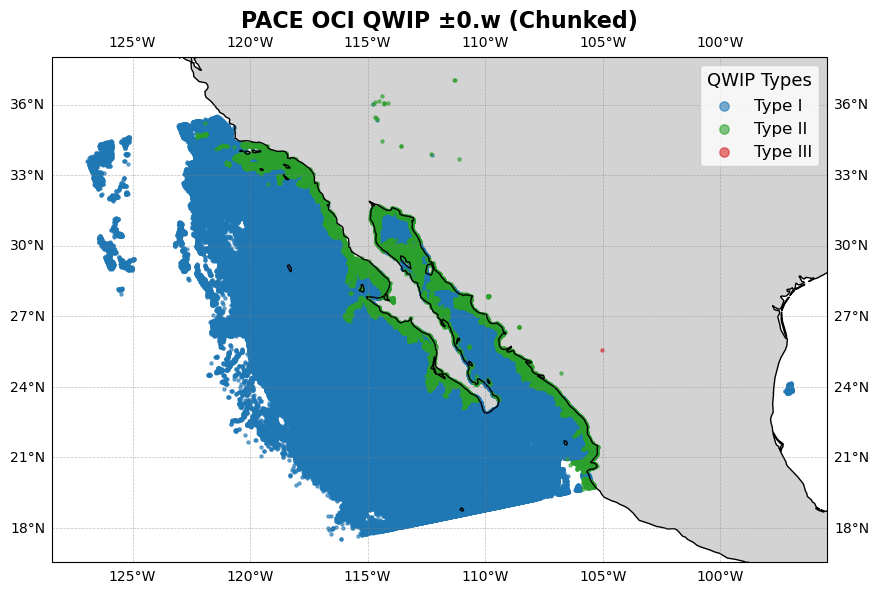

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define figure and map projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray', alpha=0.5)

# Scatter the QWIP points
ax.scatter(lon_all[ind_400A_all], lat_all[ind_400A_all],
           s=5, alpha=0.6, color="#1f77b4", label="Type I")  # blue
ax.scatter(lon_all[ind_500A_all], lat_all[ind_500A_all],
           s=5, alpha=0.6, color="#2ca02c", label="Type II")  # green
ax.scatter(lon_all[ind_600A_all], lat_all[ind_600A_all],
           s=5, alpha=0.6, color="#d62728", label="Type III")  # red/brown

# Add legend
ax.legend(title="QWIP Types", markerscale=3, fontsize=12, title_fontsize=13)

# Titles
ax.set_title("PACE OCI QWIP ±0.w (Chunked)", fontsize=16, fontweight="bold")

plt.show()


## Testing over time

In [11]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import earthaccess
import xarray as xr

# login to earthaccess
auth = earthaccess.login(persist=True)

# define kelp box
kelp_bbox = {
    "lon_min": -120.75,
    "lon_max": -119,
    "lat_min": 33.5,
    "lat_max": 34.5,
}

In [12]:
def run_qwip_chunked(ds, tol=0.2, lines_per_chunk=32):
    """
    Run QWIP per chunk, return only good (±tol) Type I/II/III pixels + coords.
    """

    # --- wavelengths ---
    wavelengths = ds["wavelength_3d"].values.astype(float)
    vis = (wavelengths >= 400) & (wavelengths <= 700)
    wavelengths_vis = wavelengths[vis]

    n_lines = ds.sizes["number_of_lines"]

    # --- output containers ---
    all_lat, all_lon = [], []
    all_ind_400A, all_ind_500A, all_ind_600A = [], [], []

    # --- chunk loop ---
    for i0 in range(0, n_lines, lines_per_chunk):
        i1 = min(i0 + lines_per_chunk, n_lines)

        Rrs_chunk = (
            ds["Rrs"]
            .isel(number_of_lines=slice(i0, i1))
            .sel(wavelength_3d=wavelengths_vis)
        )

        lat_chunk = ds["latitude"].isel(number_of_lines=slice(i0, i1))
        lon_chunk = ds["longitude"].isel(number_of_lines=slice(i0, i1))

        # reshape → (n_samples, n_wl)
        Rrs_np = (
            Rrs_chunk
            .transpose("number_of_lines", "pixels_per_line", "wavelength_3d")
            .values
        )
        rrs = Rrs_np.reshape(-1, Rrs_np.shape[-1])

        # mask invalid
        rrs[rrs <= 0] = np.nan
        good = np.all(np.isfinite(rrs), axis=1)
        if not np.any(good):
            continue

        rrs = rrs[good]

        # QWIP
        avw = calc_avw(wavelengths_vis, rrs)
        results = process_qwip_data(wavelengths_vis, rrs, avw)

        # strict QWIP filter
        good_qwip = np.abs(results["QWIP_Score"]) <= tol
        if not np.any(good_qwip):
            continue

        # append
        all_ind_400A.append(results["ind_400A"][good_qwip])
        all_ind_500A.append(results["ind_500A"][good_qwip])
        all_ind_600A.append(results["ind_600A"][good_qwip])

        lat_flat = lat_chunk.values.reshape(-1)[good][good_qwip]
        lon_flat = lon_chunk.values.reshape(-1)[good][good_qwip]

        all_lat.append(lat_flat)
        all_lon.append(lon_flat)

    # concatenate once
    return (
        np.concatenate(all_lat),
        np.concatenate(all_lon),
        np.concatenate(all_ind_400A),
        np.concatenate(all_ind_500A),
        np.concatenate(all_ind_600A),
    )
    print("Chunk lines", i0, "-", i1, "good pixels:", np.sum(good), 
          "good QWIP:", np.sum(good_qwip))

In [13]:
def kelp_color_stats(lat, lon, t1, t2, t3, roi):
    in_roi = (
        (lon >= roi["lon_min"]) & (lon <= roi["lon_max"]) &
        (lat >= roi["lat_min"]) & (lat <= roi["lat_max"])
    )

    t1 = t1[in_roi]
    t2 = t2[in_roi]
    t3 = t3[in_roi]

    n = t1.sum() + t2.sum() + t3.sum()
    if n == 0:
        return None

    return {
        "type1_frac": t1.sum() / n,
        "type2_frac": t2.sum() / n,
        "type3_frac": t3.sum() / n,
        "n_valid": n,
    }


## Pulling 3/1/25 - 3/15/25

In [14]:
import pandas as pd 

dates = pd.date_range("2025-03-01", "2025-03-15", freq="D")
records = []

for date in dates:
    # Open L2 PACE OCI data for that day
    results = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP",
        temporal=(str(date.date()), str(date.date())),
        bounding_box=(kelp_bbox["lon_min"], kelp_bbox["lat_min"],
                      kelp_bbox["lon_max"], kelp_bbox["lat_max"])
    )
    if not results:
        continue

    files = earthaccess.open(results)
    dtree = xr.open_datatree(files[0], decode_timedelta=False)
    ds = xr.merge(dtree.to_dict().values()).unify_chunks()

    lat, lon, t1, t2, t3 = run_qwip_chunked(ds)
    stats = kelp_color_stats(lat, lon, t1, t2, t3, kelp_bbox)
    if stats:
        stats["date"] = date
        records.append(stats)

df = pd.DataFrame(records).set_index("date")

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483:

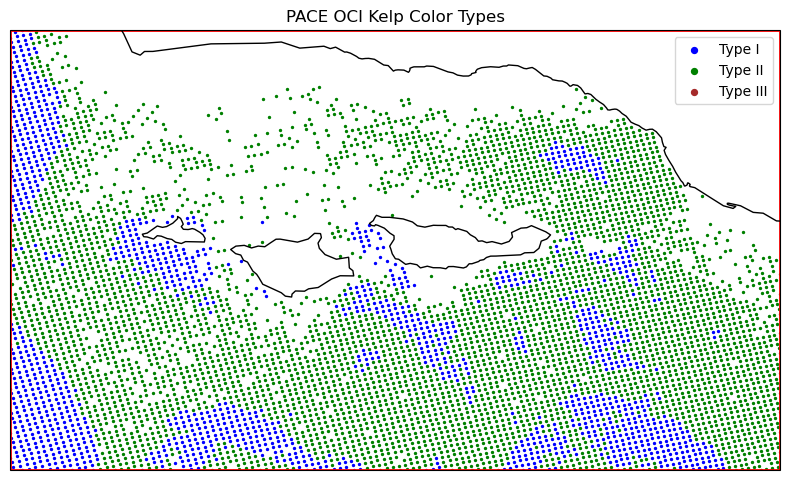

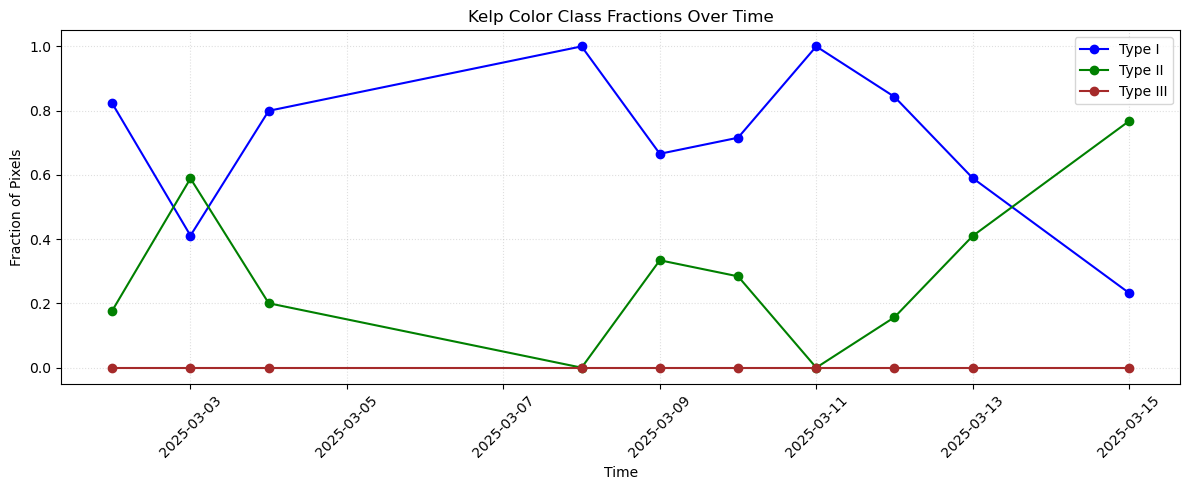

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Subset the last processed date or any date you want to map
lat_map = lat
lon_map = lon
t1_map, t2_map, t3_map = t1, t2, t3

# Bounding box for highlighting
lon_min, lon_max = kelp_bbox["lon_min"], kelp_bbox["lon_max"]
lat_min, lat_max = kelp_bbox["lat_min"], kelp_bbox["lat_max"]

# Create figure
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Zoom in a bit on the bbox
ax.set_extent(
    [lon_min, lon_max, lat_min, lat_max],
    crs=ccrs.PlateCarree()
)

# Scatter each color type
ax.scatter(lon_map[t1_map], lat_map[t1_map], s=2, c="blue", label="Type I")
ax.scatter(lon_map[t2_map], lat_map[t2_map], s=2, c="green", label="Type II")
ax.scatter(lon_map[t3_map], lat_map[t3_map], s=2, c="brown", label="Type III")

# Bounding box
ax.add_patch(Rectangle((lon_min, lat_min),
                       lon_max-lon_min,
                       lat_max-lat_min,
                       edgecolor='red', facecolor='none',
                       linewidth=2, transform=ccrs.PlateCarree()))

ax.set_title("PACE OCI Kelp Color Types")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(markerscale=3)
ax.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 5))

custom_colors = {"Type I":"blue", "Type II":"green", "Type III":"brown"}

ax.plot(df.index, df["type1_frac"], 'o-', label="Type I", color=custom_colors["Type I"])
ax.plot(df.index, df["type2_frac"], 'o-', label="Type II", color=custom_colors["Type II"])
ax.plot(df.index, df["type3_frac"], 'o-', label="Type III", color=custom_colors["Type III"])

ax.set_xlabel("Time")
ax.set_ylabel("Fraction of Pixels")
ax.set_title("Kelp Color Class Fractions Over Time")
ax.grid(True, linestyle=":", alpha=0.4)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()